In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import re
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import json
import math
import os

import matplotlib
matplotlib.rcParams['font.sans-serif'] = "Helvetica"
matplotlib.rcParams['font.family'] = "sans-serif"

In [2]:
def get_dumpsys_df(run, fps, res, mem_state, suffix):
    with open(f'pss_logs/{fps}fps{res}p_{run}{mem_state[0].lower()}_{suffix}') as f:
        data = f.read()
        f.close()
    
    data = [line.strip() for line in data.split('\n******************************\n')][:-1]
    
    rows = []
    
    count = 0
    
    for d in data:
        count += 1
        try:
            time = float(re.search(r'(\d+)$', d).group(1))
        except AttributeError as e:
            print(e)
            print(d)
        match = re.search(r'TOTAL:\s+(\d+)', d)
        if match != None:
            pss = float(match.group(1))/1024
            rows.append({
                'count': count,
                'time': time,
                'pss': pss
            })

    dumpsys_df = pd.DataFrame(rows)
    dumpsys_df['fps'] = fps
    dumpsys_df['res'] = res
    dumpsys_df['mem_state'] = mem_state
    dumpsys_df['run'] = run
    dumpsys_df['process'] = suffix
    return dumpsys_df

In [3]:
dumpsys_df = pd.DataFrame()

for run in range(1, 6+1):
    for fps in [60, 30]:
        for res in [1080, 720, 480, 360, 240]:
            for mem_state in ['critical', 'moderate', 'normal']:
                for suffix in ['base', 'tab0', 'media']:
                    dumpsys_df = dumpsys_df.append(get_dumpsys_df(run, fps, res, mem_state, suffix), ignore_index=True)

In [4]:
dumpsys_df

,count,time,pss,fps,res,mem_state,run,process
0,1,1.624830e+09,131.408203,60,1080,critical,1,base
1,2,1.624830e+09,200.745117,60,1080,critical,1,base
2,3,1.624830e+09,202.672852,60,1080,critical,1,base
3,4,1.624831e+09,200.820312,60,1080,critical,1,base
4,5,1.624831e+09,159.664062,60,1080,critical,1,base
...,...,...,...,...,...,...,...,...
10636,21,1.624884e+09,8.026367,30,240,normal,6,media
10637,22,1.624884e+09,8.049805,30,240,normal,6,media
10638,23,1.624884e+09,8.018555,30,240,normal,6,media
10639,24,1.624884e+09,8.018555,30,240,normal,6,media


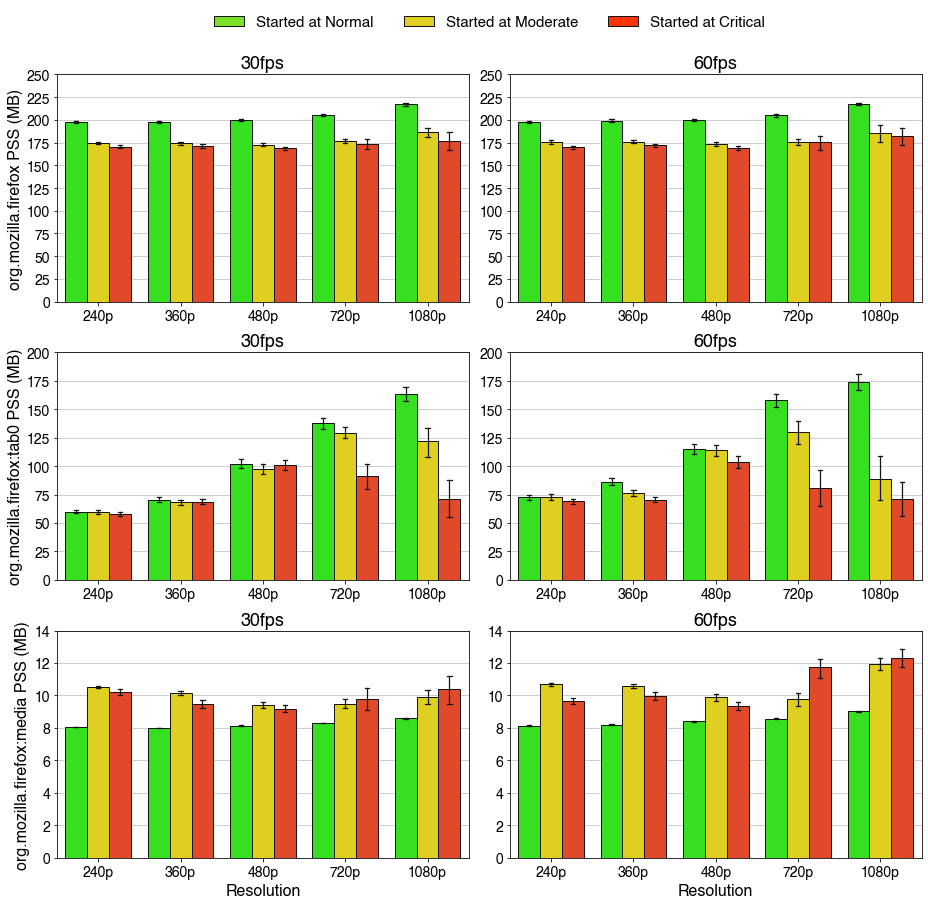

In [5]:
def plot_frames_dropped(ax, fps, process, ylabel_prefix):
    
    sns.barplot(ax=ax, data=dumpsys_df.loc[dumpsys_df['process'] == process].loc[dumpsys_df['fps'] == fps], x='res', y='pss',
                hue='mem_state',
                hue_order=['normal', 'moderate', 'critical'], 
                palette={'normal': '#1eff00', 'moderate': '#ffea00', 'critical': '#ff350a'},
                edgecolor='#141414', linewidth=1,
                capsize=.05, errwidth=1.25, errcolor='#141414')
                
    
    ax.set_title(f'{fps}fps', fontsize=18)
    if process == 'media':
        ax.set_xlabel('Resolution', fontsize=16)
    else:
        ax.set_xlabel('', fontsize=16)
    if fps==60:
        ax.set_ylabel('', fontsize=16)
    else:
        ax.set_ylabel(f'{ylabel_prefix} PSS (MB)', fontsize=16)

    if process == 'base':
        ticks = np.arange(0,250+1,25)
    elif process == 'tab0':
        ticks = np.arange(0,200+1,25)
    else:
        ticks = np.arange(0,14+1,2)
        
    ax.set_yticks(ticks)
    ax.set_yticklabels(ticks, rotation=0, fontsize=14)

    ax.set_xticklabels(['240p', '360p', '480p', '720p', '1080p'], rotation=0, fontsize=14)

    ax.set_axisbelow(True)
    ax.yaxis.grid(color='#C2C2C2')

    ax.get_legend().remove()


fig, axes = plt.subplots(3, 2, figsize=(13,12))

plot_frames_dropped(axes[0][0], 30, 'base', 'org.mozilla.firefox')
plot_frames_dropped(axes[0][1], 60, 'base', 'org.mozilla.firefox')
plot_frames_dropped(axes[1][0], 30, 'tab0', 'org.mozilla.firefox:tab0')
plot_frames_dropped(axes[1][1], 60, 'tab0', 'org.mozilla.firefox:tab0')
plot_frames_dropped(axes[2][0], 30, 'media', 'org.mozilla.firefox:media')
plot_frames_dropped(axes[2][1], 60, 'media', 'org.mozilla.firefox:media')

plt.tight_layout()

p1 = mpatches.Patch(color='#7BE026', label='Started at Normal', ec='#141414', lw=1)
p2 = mpatches.Patch(color='#DFCF21', label='Started at Moderate', ec='#141414', lw=1)
p3 = mpatches.Patch(color='#ff350a', label='Started at Critical', ec='#141414', lw=1)

axes[0][0].legend(handles=[p1,p2,p3], bbox_to_anchor=(0.36, 1.3), loc=2, fontsize=15, borderaxespad=0., borderpad=0.6, ncol=3, frameon=False)

plt.savefig(f"./footprint_nexus5_all.jpg", format="jpg" , dpi=300, bbox_inches='tight', pad_inches=0.05)

In [6]:
dumpsys_df.groupby(['fps', 'res', 'mem_state', 'run', 'count']).sum().to_csv('temp')
dumpsys_sum_df = pd.read_csv('temp')
dumpsys_sum_df

,fps,res,mem_state,run,count,time,pss
0,30,240,critical,1,1,3.249674e+09,142.293945
1,30,240,critical,1,2,4.874511e+09,277.088867
2,30,240,critical,1,3,4.874511e+09,254.704102
3,30,240,critical,1,4,4.874511e+09,253.186523
4,30,240,critical,1,5,4.874511e+09,254.518555
...,...,...,...,...,...,...,...
3629,60,1080,normal,6,20,4.874633e+09,428.259766
3630,60,1080,normal,6,21,4.874633e+09,432.294922
3631,60,1080,normal,6,22,4.874633e+09,438.828125
3632,60,1080,normal,6,23,4.874633e+09,438.386719


In [7]:
dumpsys_df.groupby(['fps', 'res', 'mem_state', 'run', 'count']).first().to_csv('temp')
temp_df = pd.read_csv('temp')
os.system("rm temp")
dumpsys_sum_df['time'] = temp_df['time']
dumpsys_sum_df

,fps,res,mem_state,run,count,time,pss
0,30,240,critical,1,1,1.624837e+09,142.293945
1,30,240,critical,1,2,1.624837e+09,277.088867
2,30,240,critical,1,3,1.624837e+09,254.704102
3,30,240,critical,1,4,1.624837e+09,253.186523
4,30,240,critical,1,5,1.624837e+09,254.518555
...,...,...,...,...,...,...,...
3629,60,1080,normal,6,20,1.624878e+09,428.259766
3630,60,1080,normal,6,21,1.624878e+09,432.294922
3631,60,1080,normal,6,22,1.624878e+09,438.828125
3632,60,1080,normal,6,23,1.624878e+09,438.386719


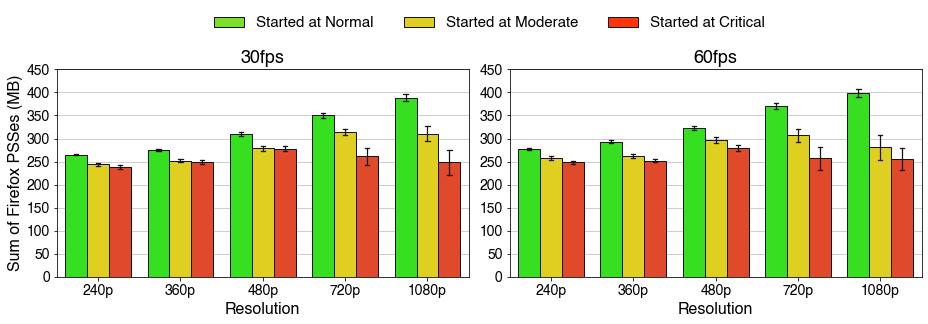

In [8]:
def plot_frames_dropped(ax, fps):
    
    sns.barplot(ax=ax, data=dumpsys_sum_df.loc[dumpsys_sum_df['fps'] == fps], x='res', y='pss',
                hue='mem_state',
                hue_order=['normal', 'moderate', 'critical'], 
                palette={'normal': '#1eff00', 'moderate': '#ffea00', 'critical': '#ff350a'},
                edgecolor='#141414', linewidth=1,
                capsize=.05, errwidth=1.25, errcolor='#141414')
                
    
    ax.set_title(f'{fps}fps', fontsize=18)
    ax.set_xlabel('Resolution', fontsize=16)
    if fps==60:
        ax.set_ylabel('', fontsize=16)
    else:
        ax.set_ylabel(f'Sum of Firefox PSSes (MB)', fontsize=16)

    ticks = np.arange(0,450+1,50)
    ax.set_yticks(ticks)
    ax.set_yticklabels(ticks, rotation=0, fontsize=14)

    ax.set_xticklabels(['240p', '360p', '480p', '720p', '1080p'], rotation=0, fontsize=14)

    ax.set_axisbelow(True)
    ax.yaxis.grid(color='#C2C2C2')

    ax.get_legend().remove()


fig, axes = plt.subplots(1, 2, figsize=(13,4))

plot_frames_dropped(axes[0], 30)
plot_frames_dropped(axes[1], 60)

plt.tight_layout()

p1 = mpatches.Patch(color='#7BE026', label='Started at Normal', ec='#141414', lw=1)
p2 = mpatches.Patch(color='#DFCF21', label='Started at Moderate', ec='#141414', lw=1)
p3 = mpatches.Patch(color='#ff350a', label='Started at Critical', ec='#141414', lw=1)

axes[0].legend(handles=[p1,p2,p3], bbox_to_anchor=(0.36, 1.3), loc=2, fontsize=15, borderaxespad=0., borderpad=0.6, ncol=3, frameon=False)

plt.savefig(f"./footprint_nexus5_sum_all.jpg", format="jpg" , dpi=300, bbox_inches='tight', pad_inches=0.05)

[  0  50 100 150 200 250 300 350 400 450 500]


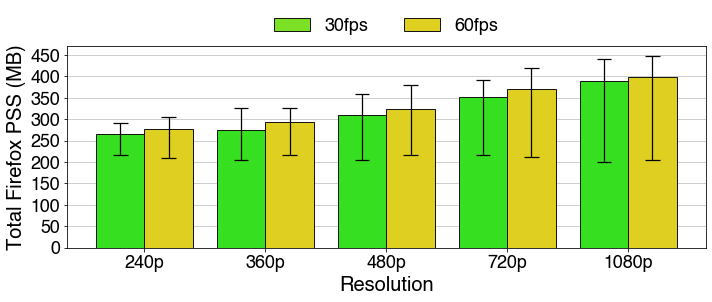

In [44]:
FONT_SM = 18
FONT_LR = 20

def get_min(inp):
    fps, res = inp[0], inp[1]
#     print(min(list(dumpsys_sum_df.loc[dumpsys_sum_df['mem_state'] == 'normal'].loc[dumpsys_sum_df['res'] == res].loc[dumpsys_sum_df['fps'] == fps]['pss'])))
    return np.min((dumpsys_sum_df.loc[dumpsys_sum_df['mem_state'] == 'normal'].loc[dumpsys_sum_df['res'] == res].loc[dumpsys_sum_df['fps'] == fps]['pss']))

def get_max(inp):
    fps, res = inp
    return np.max((dumpsys_sum_df.loc[dumpsys_sum_df['mem_state'] == 'normal'].loc[dumpsys_sum_df['res'] == res].loc[dumpsys_sum_df['fps'] == fps]['pss']))

qualities = [
    (30, 240),
    (30, 360),
    (30, 480),
    (30, 720),
    (30, 1080),
    (60, 240),
    (60, 360),
    (60, 480),
    (60, 720),
    (60, 1080)
]
    
def plot_frames_dropped(ax):
    
    sns.barplot(ax=ax, data=dumpsys_sum_df.loc[dumpsys_sum_df['mem_state'] == 'normal'], x='res', y='pss',
                hue='fps',
                hue_order=[30, 60], 
                ci=None,
                palette={30: '#1eff00', 60: '#ffea00'},
                edgecolor='#141414', linewidth=1)
#                 capsize=.05, errwidth=1.25, errcolor='#141414')
    
#     ax.set_title(f'{fps}fps', fontsize=18)
    ax.set_xlabel('Resolution', fontsize=FONT_LR)
    
    ax.set_ylabel(f'Total Firefox PSS (MB)', fontsize=FONT_LR)

    ticks = np.arange(0,500+1,50)
    print(ticks)
    ax.set_yticks(ticks)
    ax.set_yticklabels(ticks, rotation=0, fontsize=FONT_SM)

    ax.set_xticklabels(['240p', '360p', '480p', '720p', '1080p'], rotation=0, fontsize=FONT_SM)

    ax.set_axisbelow(True)
    ax.yaxis.grid(color='#C2C2C2')

    ax.get_legend().remove()
    
    # add the lines for the errors 
    count = 0
    for p in ax.patches:
        x = p.get_x()  # get the bottom left x corner of the bar
        w = p.get_width()  # get width of bar
        h = p.get_height()  # get height of bar
        ax.vlines(x+w/2, get_min(qualities[count]), get_max(qualities[count]), color='k', lw=1.25)  # draw a vertical line
        ax.hlines(get_min(qualities[count]), x+w/2-0.12/2,x+w/2+0.12/2, color='k', lw=1.25)  # draw a vertical line
        ax.hlines(get_max(qualities[count]), x+w/2-0.12/2,x+w/2+0.12/2, color='k', lw=1.25)
        count += 1
fig, ax = plt.subplots(1, 1, figsize=(10,3.75))

plot_frames_dropped(ax)

def change_width(ax, new_value) :
    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width - new_value

        # we change the bar width
        patch.set_width(new_value)

        # we recenter the bar
        patch.set_x(patch.get_x() + diff * .5)

# change_width(ax, 0.25)

plt.tight_layout()

p1 = mpatches.Patch(color='#7BE026', label='30fps', ec='#141414', lw=1)
p2 = mpatches.Patch(color='#DFCF21', label='60fps', ec='#141414', lw=1)

# p1 = mpatches.Patch(color='#7BE026', label='Started at Normal', ec='#141414', lw=1)
# p2 = mpatches.Patch(color='#DFCF21', label='Started at Moderate', ec='#141414', lw=1)
# p3 = mpatches.Patch(color='#ff350a', label='Started at Critical', ec='#141414', lw=1)

ax.legend(handles=[p1,p2], bbox_to_anchor=(0.5, 1.1), loc='center', fontsize=FONT_SM, borderaxespad=0., borderpad=0.6, ncol=2, frameon=False)

plt.savefig(f"./footprint_normal.jpg", format="jpg" , dpi=300, bbox_inches='tight', pad_inches=0.05)

In [10]:
def get_vid_df(exp_name, time_offset=-1, interval=500):
    
    if interval < 500:
        interval = 500
    div = int(interval / 500)
    
    with open(f'pss_nexus5_vid_logs/log_video_{exp_name}') as file:

        rows = []
        buffer_rows = []

        for line in file.readlines():
            line = line.strip().split('\t')
            vid_data = json.loads(line[7])
            buffer_val = float(line[2])
            buffer_time = float(line[0])
            buffer_rows.append([buffer_time, buffer_val])
            
            for vid_log in vid_data:
#                 print(vid_log)
                if next((row for row in rows if row[0] == vid_log['logCount']), None) == None:
                    
                    if vid_log['logCount'] == 0:
                        row = []
                        row.append(vid_log['logCount'])
                        row.append(vid_log['timeStamp'])
                        row.append(vid_log['timeElapsed'])
                        row.append(vid_log['totalFrames'])
                        row.append(vid_log['droppedFrames'])
                        row.append(vid_log['frameRate'])
                        rows.append(row)
                    elif int(vid_log['logCount']) % div == 0:
                        row = []
                        row.append(vid_log['logCount'])
                        row.append(vid_log['timeStamp'])
                        row.append(vid_log['timeElapsed'])
                        row.append(vid_log['totalFrames'])
                        row.append(vid_log['droppedFrames'])
                        prevTimeElapsed = rows[-1][2]
                        prevTotalFrames = rows[-1][3]
                        prevDroppedFrames = rows[-1][4]
                        frameRate = ((vid_log['totalFrames'] - prevTotalFrames) - (vid_log['droppedFrames'] - prevDroppedFrames)) / (vid_log['timeElapsed'] - prevTimeElapsed)
                        row.append(frameRate)
                        rows.append(row)
                        
    vid_df = pd.DataFrame(rows, columns=['logCount', 'Time', 'timeElapsed', 'totalFrames', 'droppedFrames', 'Frame Rate'])
    vid_df['Time'] = (vid_df['Time'] - vid_df.iloc[0]['Time'])/1000 if time_offset == -1 else vid_df['Time']/1000 - time_offset
    
    buffer_df = pd.DataFrame(buffer_rows, columns=['time', 'buffer'])
    return vid_df, buffer_df

In [11]:
vid_df = pd.DataFrame()

for run in range(1, 4+1):
    for fps in [60, 30]:
        for res in [1080, 720, 480, 360, 240]:
            for mem_state in ['normal']:
                temp_df, buffer_df = get_vid_df(f'{fps}fps{res}p_{run}{mem_state[0].lower()}')
                last_row = temp_df.iloc[-1]
                frames_dropped = (last_row['droppedFrames']/last_row['totalFrames'])*100
                
                a = buffer_df.iloc[2]
                time_buf_empty = a['time']
                buffer_buf_empty = a['buffer']
                comp = float(time_buf_empty)
                df = dumpsys_sum_df
                df = df.loc[df['fps'] == fps].loc[df['res'] == res].loc[df['run'] == run].loc[df['mem_state'] == mem_state]
                a = df.loc[df['time'] >= comp].iloc[0]['time']
                some_dff = a-comp
                b = df.loc[df['time'] <= comp].iloc[0]['time']
                if abs(a-comp) < abs(b-comp):
                    final = a
                else:
                    final = a
                some_dff = final-comp
                pss_buf_empty = df.loc[df['fps'] == fps].loc[df['res'] == res].loc[df['run'] == run].loc[df['mem_state'] == mem_state].loc[df['time'] == final]['pss'].iloc[0]

                a = buffer_df.loc[buffer_df['buffer'] >= 30-2].iloc[0]
                time_buf_half = a['time']
                buffer_buf_half = a['buffer']
                comp = float(time_buf_half)
                df = dumpsys_sum_df
                df = df.loc[df['fps'] == fps].loc[df['res'] == res].loc[df['run'] == run].loc[df['mem_state'] == mem_state]
                a = df.loc[df['time'] >= comp].iloc[0]['time']
                # print(a, b)
                b = df.loc[df['time'] <= comp].iloc[0]['time']
                if abs(a-comp) < abs(b-comp):
                    final = a
                else:
                    final = b
                pss_buf_half = df.loc[df['fps'] == fps].loc[df['res'] == res].loc[df['run'] == run].loc[df['mem_state'] == mem_state].loc[df['time'] == final]['pss'].iloc[0]

                a = buffer_df.loc[buffer_df['buffer'] >= 60-2].iloc[0]
                time_buf_full = a['time']
                buffer_buf_full = a['buffer']
                comp = float(time_buf_full)
                df = dumpsys_sum_df
                df = df.loc[df['fps'] == fps].loc[df['res'] == res].loc[df['run'] == run].loc[df['mem_state'] == mem_state]
                a = df.loc[df['time'] >= comp].iloc[0]['time']
                # print(a, b)
                b = df.loc[df['time'] <= comp].iloc[0]['time']
                if abs(a-comp) < abs(b-comp):
                    final = a
                else:
                    final = b
                pss_buf_full = df.loc[df['fps'] == fps].loc[df['res'] == res].loc[df['run'] == run].loc[df['mem_state'] == mem_state].loc[df['time'] == final]['pss'].iloc[0]
                
                vid_df = vid_df.append(pd.DataFrame([{
                    'run': run, 'fps': fps, 'res': res, 'mem_state': mem_state, 'frames_dropped': frames_dropped,
                    
                    'time_buf_empty': time_buf_empty,
                    'buffer_buf_empty': buffer_buf_empty,
                    'pss_buf_empty': pss_buf_empty,

                    'time_buf_half': time_buf_half,
                    'buffer_buf_half': buffer_buf_half,
                    'pss_buf_half': pss_buf_half,
                    
                    'time_buf_full': time_buf_full,
                    'buffer_buf_full': buffer_buf_full,
                    'pss_buf_full': pss_buf_full,
                    
                    'pss_diff_buffer_empty_to_full': pss_buf_full-pss_buf_empty,
                    'pss_diff_buffer_half_to_full': pss_buf_full-pss_buf_half,
                    'pss_diff_buffer_empty_to_half': pss_buf_half-pss_buf_empty,
                    
                    'some_dff': some_dff
                    
                }]), ignore_index=True)

In [12]:
vid_df.groupby(['fps', 'res']).mean()[['pss_diff_buffer_empty_to_full','pss_diff_buffer_half_to_full','pss_diff_buffer_empty_to_half', 'some_dff']]

pss_diff_buffer_empty_to_full  pss_diff_buffer_half_to_full  \
fps res                                                                 
30  240                        0.000000                      0.000000   
    360                      -13.007812                      4.218750   
    480                      -12.850098                    -12.850098   
    720                       37.003662                     14.113037   
    1080                      84.712646                     36.271240   
60  240                      -20.535889                     -2.257568   
    360                      -16.041260                    -16.041260   
    480                        3.414062                     -3.515625   
    720                       71.735352                     38.423096   
    1080                     122.247559                     42.509277   

          pss_diff_buffer_empty_to_half  some_dff  
fps res                                            
30  240                        0.000000    3.0950  
    360                      -17.226562    2.5875  
    480                        0.000000    2.9800  
    720                       22.890625    2.4225  
    1080                      48.441406    1.7675  
60  240                      -18.278320    3.0850  
    360                        0.000000    3.0700  
    480                        6.929688    2.6550  
    720                       33.312256    1.8400  
    1080                      79.738281    2.1300